# Credit Risk Modeling

## Introduction

Credit risk pertains to the potential that a borrower may fail to fulfill their loan obligations, posing a substantial concern for lenders like banks and financial institutions due to the possibility of financial losses, impacting profitability and stability. Evaluating and managing this risk is pivotal in lending operations, involving the utilization of diverse techniques and models. Factors such as credit history, repayment capability, loan terms, and annual income are scrutinized to assess this risk.

Various forms of credit risk include default risk, where borrowers may not meet payment obligations, credit spread risk, which involves losses due to widening credit spreads, counterparty risk, concentration risk, and country risk linked to investing or lending in specific countries due to political or economic instability.

Credit risk assessment employs several methodologies, including credit scoring models utilizing historical data and predictive variables, credit rating agencies assigning credit ratings based on repayment capacity, financial statement analysis, collateral evaluation, and consideration of qualitative factors like management quality and industry outlook.

Many organizations, especially financial institutions, evaluate credit risk for existing and potential customers, often leveraging machine learning to analyze customer data for risk profiling. Machine learning aids in determining the probability of default and assessing the financial impact on lenders in such scenarios.

In data analysis projects, the application of machine learning algorithms such as Random Forests and XGBoost aims to model and assess risks within datasets. The objective is to explore the efficacy of these algorithms in analyzing data and providing insights into various risk types, thereby enhancing lending decisions and risk management practices.

In this data analysis project, the goal is to explore the feasibility of using machine learning algorithms such as Random Forests, and XGBoost to model and assess risks within a dataset. The primary objective is to investigate whether these algorithms can effectively analyze the data and provide insights into various types of risks. 



@Authored by **Dr. Donald Kpatcha**

### Import python librairies

In [83]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, mutual_info_score, recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv


### Load the data

In [84]:
df = pd.read_csv("credit_risk_dataset.csv")
df.head(5)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


### Exploring data

In [85]:
# Exploring the size, and the features (columns) types of the data
print(" Number of lines = {} \n Number of columns = {}".format(df.shape[0], df.shape[1]))

# type of each column
print("\n Types of columns: \n \n", df.dtypes)


 Number of lines = 32581 
 Number of columns = 12

 Types of columns: 
 
 person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


##### Note

The columns meaning:

* person_age-Age: age of the custumers
* person_income-Annual:  Income
* person_home_ownership-Home:  ownership
* person_emp_length-Employment: length (in years)
* loan_intent-Loan: intent
* loan_grade-Loan: grade
* loan_amnt-Loan: amount
* loan_int_rate-Interest: interest rate
* loan_status-Loan: status (0 is non default 1 is default)
* loan_percent_income-Percent: percentage
* cb_person_default_on_file-Historical: default status
* cb_preson_cred_hist_length-Credit: history length


In [86]:
# determine unique values of each object type column
for col in df.select_dtypes(include=['object']):
    print(col, ":" , df[col].unique())


person_home_ownership : ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent : ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade : ['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file : ['Y' 'N']


In [87]:
# Check the range of the customers age. This allows to see
df.sort_values(by='person_age').tail(5)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0,0.26,N,4
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25


##### Note
Reasonalbly the age of the 6 oldest customers (between 123 and 144) is far beyond the human life expectency. 
There could have been a problem in collecting tese informations or could be other reasons. For e.g. it 
could be the case deceased poeple whose data and personal information are not update for years.

I believe that the loan interest rate is a crucial factor in predicting credit defaults, thus I will 
drop them when building models. There is still significant amount of data for proceeding since these rows 
represent only about 0.18\% of the data.

In [88]:
# check loan grade is ordinal or not?
df.groupby('loan_grade').head(2).reset_index(drop=True).sort_values(by='loan_grade')


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
6,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
5,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
7,21,10000,OWN,6.0,VENTURE,D,1600,14.74,1,0.16,N,3
8,26,108160,RENT,4.0,EDUCATION,E,35000,18.39,1,0.32,N,4
10,25,137000,RENT,9.0,PERSONAL,E,34800,16.77,0,0.25,Y,2


### Data Pre-processing

In [89]:
# check for missing value percentage in each columm (feature)
(df.isnull().sum() / len(df)).sort_values(ascending=False)*100


loan_int_rate                 9.563856
person_emp_length             2.747000
person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

##### Note
As you can see there is a significant number of rows with missing values in the 'loan_int_rate' column, accounting for approximately 9.5% of the dataset. Upon running the previous cell, you can see that 3116 rows lack information regarding the loan interest rate. I believe that the loan interest rate is a crucial factor in predicting credit defaults. However, there is insufficient information within the existing dataset to impute these missing values, and the data description offers limited information.
Hence, I decided to remove rows with NaN values in the 'loan_int_rate' and 'person_emp_length' columns. There is still a significant amount of data available even after these removals, allowing us to continue our analysis with a reasonably sized dataset.

In [90]:
# dropping duplicate, and missing values rows 
df = df.drop_duplicates() 
df.dropna(inplace=True)


### Exploratory Data Analysis 

Value counts of 0    22435
1     6203
Name: loan_status, dtype: int64


Text(0.5, 1.0, 'Customers ever defaulted')

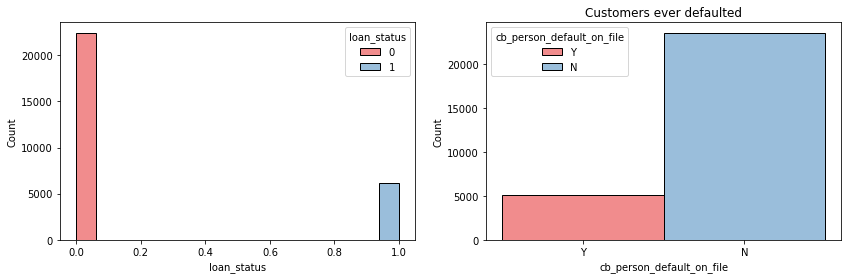

In [91]:
# check the class balance
print("Value counts of", df['loan_status'].value_counts())

fig, ax = plt.subplots(1, 2, figsize=(14,4))
sns.histplot(data=df, x="loan_status", hue="loan_status", palette = "Set1", ax= ax[0])
plt.title('Loan status of Customers')

sns.histplot(data=df, x="cb_person_default_on_file", hue="cb_person_default_on_file",\
             palette = "Set1", ax= ax[1])
plt.title('Customers ever defaulted')


##### Note
As one would have expected, in our data there are many instances that customers have no default on file. Only 17% of the data accounts for having defaulted on their files. Let's handle this class imbalance when we train the models.

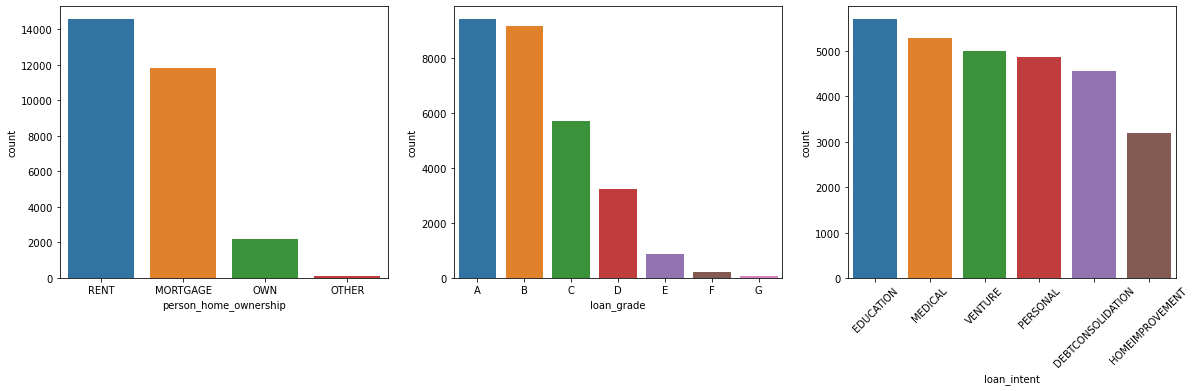

In [92]:
columns = {0:'person_home_ownership', 1: 'loan_grade', 2: 'loan_intent'}
fig, ax = plt.subplots(1,3, figsize=(20,5))

for key, val in columns.items(): 
    sns.countplot(x=val,  data=df, ax=ax[key], order = df[val].value_counts().index)
    plt.xticks(rotation=45)


##### Note
The countplots shows a preliminary glance into the categorical variables within the dataset. A significant proportion
of loan applicants do not own a home and instead reside in rental properties. The loan grades largely fall
into categories A and B, with G being the least common grade. The loan intent plot is quite interesting, 
showing that a substantial number of loan applications are associated with educational or medical purposes. 
Lets' further explore the data with the continus features. 

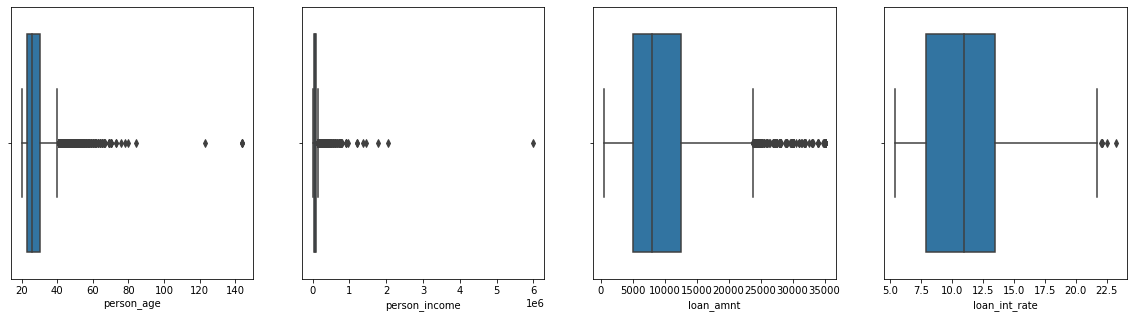

In [93]:
# Search for outliers
columns = {0:'person_age' , 1: 'person_income', 2: 'loan_amnt', 3:'loan_int_rate'}
fig, ax = plt.subplots(1,len(columns), figsize=(20, 5))
for key, val in columns.items(): 
    sns.boxplot(x=df[val], ax= ax[key])


##### Note
As already pointed above, there are some outliers in our data, e.g., a person's 
age is 140, and a income value around 6000000. We will remove these outliers from our data.

In [94]:
# assuming a persons limit is less than 90 years old for loan eligibility 
df2 = df.loc[(df['person_age'] <= 90) &  (df['person_income'] < 6.0E06)]


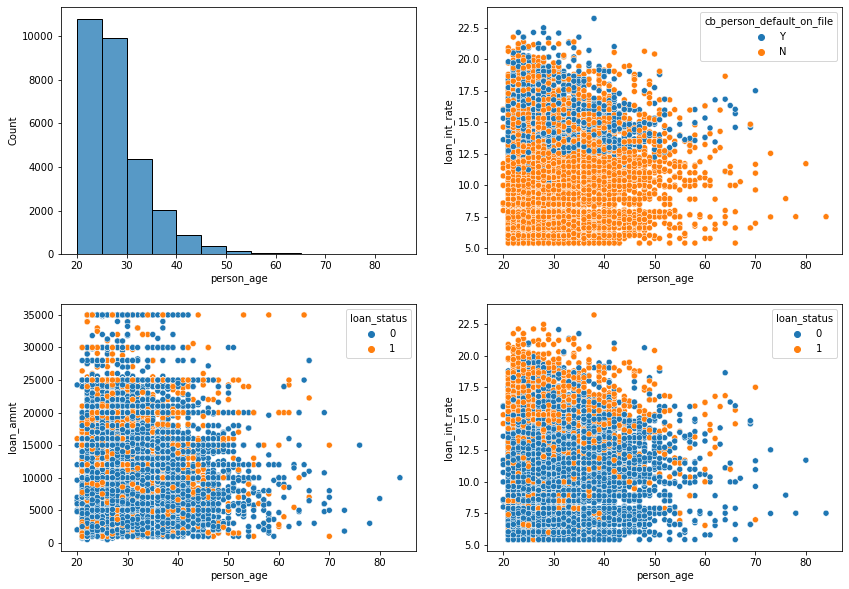

In [95]:
# Age count, and loan interest rate per age, age vs income  distribution
fig, ax = plt.subplots(2, 2, figsize=(14,10))
sns.histplot(data=df2, x ='person_age', binwidth=5, ax=ax[0,0])
sns.scatterplot(data=df2, x="person_age", y="loan_int_rate", hue='cb_person_default_on_file', ax=ax[0,1])
sns.scatterplot(data=df2, x="person_age", y="loan_amnt", hue='loan_status', ax=ax[1,0])
sns.scatterplot(data=df2, x="person_age", y="loan_int_rate", hue='loan_status', ax=ax[1,1])
plt.show()


##### Note
The majority of loan applicants fall within the 20 to 35 age bracket, shedding light on why educational
contributions constitute the largest share of loan intents. We observe also that the loan interest rate
seems higher for customers who ever defaulted, irrespective to their age.

There is no significant patterns that explains the relationship between the age and loan amount according
to the scatterplot. Similar results were obtained for loand interest rate as well.

In [96]:
# Convert categorical variables into numerical:  Yes and No values to 0 and 1
data_df = df2.copy()
data_df['cb_person_default_on_file'] = data_df.cb_person_default_on_file.map(dict(Y=1, N=0))
data_df.head(5)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,1,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,0,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,0,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,0,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,1,4


### Correlation analysis

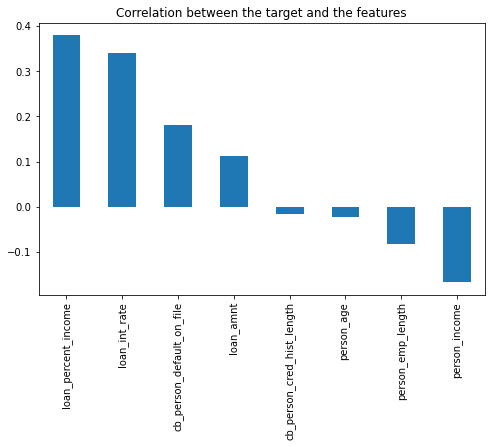

In [97]:
# check correlation between the target and the features
conti_df= data_df.select_dtypes(exclude=[object])
corr_with_tot_count = conti_df.corr()["loan_status"].sort_values(ascending=False)

plt.figure(figsize=(8,5))
corr_with_tot_count.drop("loan_status").plot.bar()
plt.title("Correlation between the target and the features")
plt.show()


##### Note
The above plot shows that the correlation between the target variable and the loan_percent_income, 
loan_int_rate, are highly positively correlated and cb_person_cred_hist_lengthhas small correlation
with the target. variable.

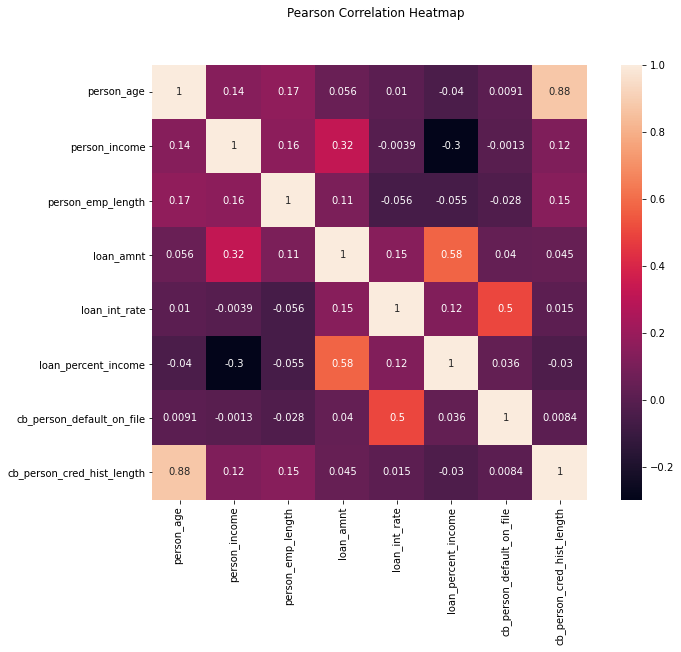

In [98]:
# check for correlation among the features
plt.figure(figsize=(12,8))
sns.heatmap(conti_df.drop(['loan_status'],axis=1).corr(), square=True, annot=True,)
plt.suptitle("Pearson Correlation Heatmap")
plt.show()


##### Note
Person correlation map indicates a high collinearity between the cb_person_cred_hist_length and the person_age. 
Following the correlation analysis, 

1. one might drop those two features, or 

2. drop only one of them, let say 'cb_person_cred_hist_length' as it can be found, this would not change the accuracy
for the randome forest classification

Thus, in this modelling, I will drop those two features.

In [99]:
# drop features 
df_final = data_df.drop(['cb_person_cred_hist_length', 'person_age'],axis=1)


### Mutual Information

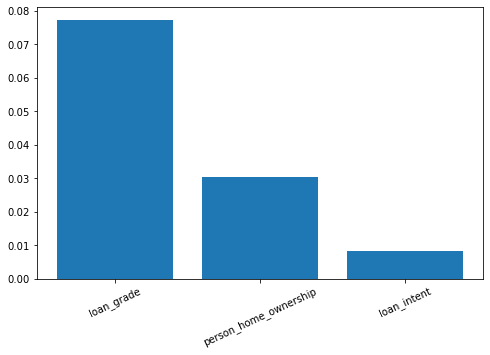

In [100]:
# returns the MI scores
def compute_mutual_information(categorical_serie):
    return mutual_info_score(categorical_serie, df_final.loan_status)

# select categorial variables excluding loan status
cat_vars = df_final.select_dtypes(include=object)

# compute the MI score between each categorical variable and the target
feature_importance_df = cat_vars.apply(compute_mutual_information).sort_values(ascending=False)

# visualize feature importance
plt.figure(figsize=(8,5))
plt.bar(feature_importance_df.index, height = feature_importance_df.values)
plt.xticks(rotation=25)
plt.show()


In [101]:
feature_importance_df


loan_grade               0.077334
person_home_ownership    0.030432
loan_intent              0.008204
dtype: float64

##### Note
Based on the MI scores, loan_intent and person_home_ownership shows very low scores and we can drop them 
for further analysis.

In [117]:
# select the final set of features
selected_features = df_final.drop(['loan_intent', 'person_home_ownership'], axis=1)


In [118]:
# Label encoding for loan grade
le = preprocessing.LabelEncoder()
selected_features['loan_grade'] = le.fit_transform(selected_features.loan_grade.values)

selected_features.head(5)


,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file
0,59000,123.0,3,35000,16.02,1,0.59,1
1,9600,5.0,1,1000,11.14,0,0.10,0
2,9600,1.0,2,5500,12.87,1,0.57,0
3,65500,4.0,2,35000,15.23,1,0.53,0
4,54400,8.0,2,35000,14.27,1,0.55,1


In [119]:
# check if necessary to encode some features
print("min(loan_amnt) = {}, max(loan_amnt) = {}"\
      .format(selected_features.loan_amnt.min(), selected_features.loan_amnt.max()))

print("min(person_income) = {}, max(person_income) = {}"\
      .format(selected_features.person_income.min(), selected_features.person_income.max()))


min(loan_amnt) = 500, max(loan_amnt) = 35000
min(person_income) = 4000, max(person_income) = 2039784


##### Note
Given that the loan_amnt and person_income are spread over large range of values,
it would be better to encode them in 0,1 range to avoid impacting the the predictability of
our models

In [120]:
# Label encoding for loan grade
mme = preprocessing.MinMaxScaler()
selected_features[['loan_amnt', 'person_income']] = \
mme.fit_transform(selected_features[['loan_amnt', 'person_income']].values)

selected_features.head(5)


,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file
0,0.027017,123.0,3,1.000000,16.02,1,0.59,1
1,0.002751,5.0,1,0.014493,11.14,0,0.10,0
2,0.002751,1.0,2,0.144928,12.87,1,0.57,0
3,0.030209,4.0,2,1.000000,15.23,1,0.53,0
4,0.024757,8.0,2,1.000000,14.27,1,0.55,1


### Model Training

In [121]:
# returns the model performance in terms of accuracy, classification report and the confusion matrix
def model_performance(y_test,y_pred, method):
    
    # calculate the accruacy of the model
    print("Accuracy score of the model", accuracy_score(y_test,y_pred))
    print("Classification report \n")
    
    #generate the classification report
    print(classification_report(y_test,y_pred))
    
    #generate the confusion matrix
    fig = plt.figure(figsize=(6,4))
    ax = fig.gca()
    cnf_matrix_log = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix_log), annot=True,cmap="Reds" , fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix: '+  method + '\n', y=1.1)


In [122]:
# select the features and the target variables
X = selected_features.drop(['loan_status'], axis=1)
y = selected_features['loan_status']

# Train and test Split using stratify sampling to solve the class imbalance problem
# I will shuffle the dataset before splitting to avoid keeping parterns
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, \
                                                    random_state=33)


#### Random Forest Classifier

Random Forests are an ensemble machine learning algorithm that can be used for both classificaion and regression tasks.
Random Forest Classifier is a popular machine learning algorithm that belongs to the ensemble learning family. It is widely used for classification tasks, where the goal is to predict the class or category of an input data point based on its features. Random Forest Classifier builds multiple decision trees during training and combines their predictions to make more accurate and robust predictions.


Accuracy score of the model 0.8772481229264886
Classification report 

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4486
           1       0.76      0.64      0.69      1241

    accuracy                           0.88      5727
   macro avg       0.83      0.79      0.81      5727
weighted avg       0.87      0.88      0.87      5727



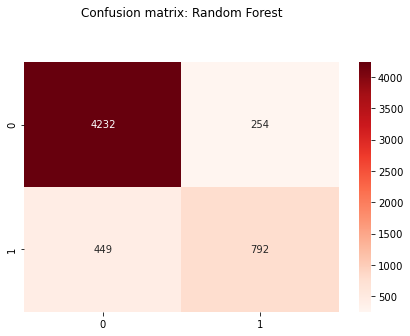

In [123]:
# setting the parameters for the model
model_rf = RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=-1,
                                  random_state=50, max_leaf_nodes=30)
# fitting the model
model_rf.fit(X_train, y_train)

# make predictions
prediction_test = model_rf.predict(X_test)

# measure the model performance
model_performance(y_test,prediction_test, 'Random Forest')


##### Note
The precision values of 90% and 76% for classes 0 and 1, respectively, signify the model's ability to accurately
identify true positive instances within each class. Specifically, for class 0, the model demonstrates high precision
(90%), implying that when it predicts a positive instance for this class, it is correct 90% of the time. On the other
hand, the lower precision of 76% for class 1 suggests that the model is somewhat less precise in identifying positive
instances for this category. The recall values of 94% for class 0 and 64% for class 1 indicate the model's effectiveness
in capturing a significant portion of true positive instances for class 0 but a comparatively lower recall for class 1.
Overall, the model excels in correctly identifying instances of class 0, but there is room for improvement in its
performance for class 1, where it may miss some positive instances. Note that class 0 indicates loan status
0 and class =1 indicates loan status 1.


### Cross validation

In [147]:
# apply k-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_rf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


Accuracy: 0.872 (0.005)


##### Note
The accuracy seems pretty consistance with the cross validation results.

### Model tunning

To optimize the performance of our RandomForest classifier, we can use a grid search approach across its 
various parameters. By systematically exploring different combinations of hyperparameter values, we can find
a configuration that improves the model's predictive capabilities. This process allows us to fine-tune the 
RandomForest classifier and achieve an optimal balance in parameter settings, ultimately improving its overall
accuracy and robustness.

In [148]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90],
    'n_estimators': [200, 500],
    'max_leaf_nodes' : [20, 30]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


In [149]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


{'bootstrap': True, 'max_depth': 80, 'max_leaf_nodes': 30, 'n_estimators': 500}

### Feature Importance Scores

Random Forests calculate feature importance by evaluating how much each feature contributes to reducing
impurity (in classification) or error (in regression) when used as a splitting criterion across the ensemble
of decision trees. Features that consistently lead to purer nodes or lower error are considered more important
and are used as the basis for feature selection.

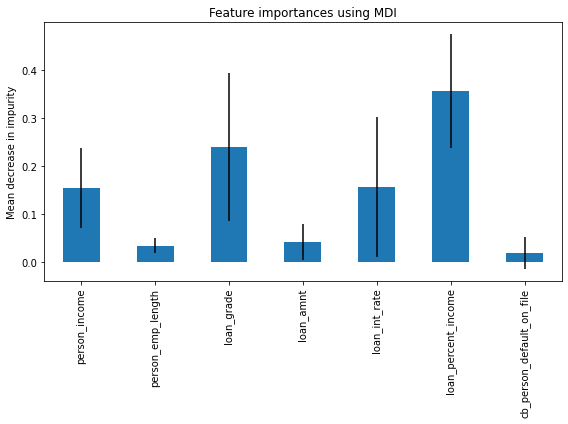

In [150]:
forest_importances = pd.Series(model_rf.feature_importances_, index=X.columns.values)
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(8,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()


##### Note
The feature imprtance given by the random forest classifier shows that the most important features 
are loan_perecent_income, loan_grade, loan_int_rate and person_income.

### XGBoost

XGBoost (Extreme Gradient Boosting) is a highly efficient and scalable machine learning algorithm that belongs to the family of gradient boosting algorithms. XGBoost is an optimized implementation of gradient boosting algorithms. It builds an ensemble of weak learners (usually decision trees) sequentially, where each new tree corrects errors made by the previous ones. XGBoost uses gradient descent techniques to minimize a loss function. Rooted in the decision tree methodology, XGBoost's strength lies in its ability to sequentially build a multitude of weak learners, iteratively refining the model's predictive accuracy. It has gained immense popularity and has been widely adopted in various machine learning competitions and real-world applications due to its exceptional performance and versatility. XGBoost is used for both regression and classification tasks and is known for its speed, accuracy, and ability to handle large-scale datasets.

In the upcoming analysis, we will assess whether integrating an XGBoost model
can yield enhancements over the results obtained from the random forest classifier.

In [151]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [152]:
# Convert y to one-dimensional array (vector)
y_train = np.array(y_train).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))


In [153]:
# fit and train the model
model_xgb = XGBClassifier(learning_rate=0.01,
                            n_estimators=50,
                            max_depth=6,
                            random_state=42,
                            n_jobs=-1)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)


Accuracy score of the model 0.8032128514056225
Classification report 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4486
           1       0.97      0.09      0.17      1241

    accuracy                           0.80      5727
   macro avg       0.89      0.55      0.53      5727
weighted avg       0.84      0.80      0.73      5727



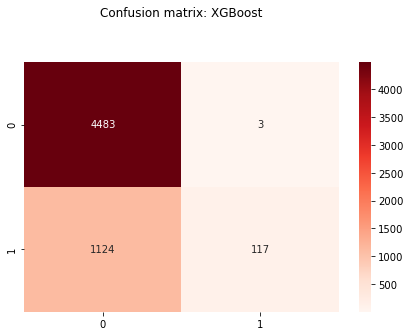

In [154]:
# measure the model performance
model_performance(y_test, y_pred, 'XGBoost')


##### Note
Precision values of 91% for class 0 and 77% for class 1 indicate the model's ability to accurately identify
instances within each class, with a higher precision for class 0. The recall values of 95% for class 0 and 
64% for class 1 reflect the model's effectiveness in capturing the majority of true positive instances for 
class 0, but a relatively lower recall for class 1, suggesting it may miss some positive instances in this category. 
Overall there is not much improvement over the random forest classifier.


### Model tunning (GridSearch)

Next, we can perform hyperparameter tuning using grid search to determine an optimal set of hyperparameters for 
our XGBoost model. I have only tried two paramaters here for simplicity. But we can define more and values and other
parameters.


In [155]:
# grid search for the XGBClassifier
clf = GridSearchCV(
        model_xgb,
        {"max_depth": [2, 4, 6], "n_estimators": [50, 100, 200]},
        verbose=1,
        n_jobs=2,
    )
clf.fit(X_train,y_train)
print("score = ", clf.best_score_)
print("best parameters = ", clf.best_params_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
score =  0.8737504967808221
best parameters =  {'max_depth': 6, 'n_estimators': 200}


### K-fold cross validation
XGBoost supports k-fold cross validation using the cv() method. In tthe following,  xgb_cv contains train and
test auc metrics for each boosting round.


In [156]:
# define data_dmatrix
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(X.columns.values))
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(X.columns.values))


In [160]:
from xgboost import cv

# setting the parameters
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

# apply cross validation
xgb_cv = cv(dtrain=dtrain, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

xgb_cv.head(5)


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.774323,0.004307,0.771813,0.008931
1,0.862276,0.003271,0.856754,0.005573
2,0.853210,0.002018,0.846235,0.006649
3,0.867219,0.000940,0.861085,0.004875
4,0.869603,0.000299,0.863427,0.005857


### Feature Importance Scores 

XGBoost assigns an importance score to each feature based on how much it contributes to the model's performance. This score is calculated by analyzing how often and how effectively a feature is used in decision trees during the boosting process. Features that are frequently used to make important decisions in the trees are assigned higher importance scores.

Features with high importance scores are typically the most informative and contribute significantly to the model's predictive power. 

In [161]:
# training the model again using the following method to get feature importance with feature names
evals = [(dtrain, 'train'), (dtest, 'validation')]
model_xgb_2 = xgb.train(params, dtrain, num_boost_round=60, 
                  early_stopping_rounds=50, maximize=False, evals=evals, verbose_eval=10)


[0]	train-logloss:0.50311	validation-logloss:0.50254
[10]	train-logloss:0.40765	validation-logloss:0.40545
[20]	train-logloss:0.37361	validation-logloss:0.37026
[30]	train-logloss:0.34965	validation-logloss:0.34557
[40]	train-logloss:0.33438	validation-logloss:0.33010
[50]	train-logloss:0.32573	validation-logloss:0.32138
[59]	train-logloss:0.32251	validation-logloss:0.31831


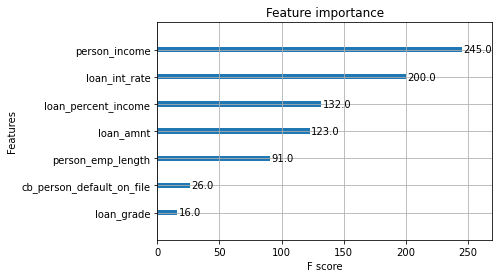

In [162]:
# plot the fearures according to their importance
xgb.plot_importance(model_xgb_2)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

##### Note

The high feature importance of "person_income" and "loan_int_rate" in the XGBoost model indicates that these variables significantly influence the model's predictions. 

- Loan Interest Rate (loan_int_rate): The interest rate on a loan directly affects the cost of borrowing. A higher interest rate can impact a borrower's ability to repay the loan, potentially increasing the risk of default.

- Person Income (person_income): The income of the individual is often a crucial determinant in assessing their financial stability and capacity to handle loans. Higher income levels generally correlate with a lower likelihood of defaulting on loans, making it a key feature for predictive models.

### Conclusions


* Comparable Performance: Upon evaluation, both the Random Forest Classifier and XGBoost models demonstrate similar performance in addressing the designated classification task.
* Limited Experimentation and Hyperparameter Optimization: It's important to note the constraints of our experiments, as neither model has been explored across the full spectrum of hyperparameter settings. Further refinement in this regard could potentially bolster their predictive capabilities.
* Financially Aligned Feature Importance: Notably, the examination of feature importance within the XGBoost model, particularly emphasizing "person_income" and "loan_int_rate," resonates well with established financial principles.
* Exploring additional combinations of hyperparameters and potentially incorporating a broader set of features could yield enhancements in the performance of both models.
* Lastly, upon completion of model construction, each model is trained on the entire dataset, preparing them for deployment and awaiting new data influx.

